In [5]:
!which python
!echo $CONDA_DEFAULT_ENV

/home/users/rmovva/anaconda2/bin/python



In [2]:
# on mommadragonn conda environment
import momma_dragonn
import deeplift

In [2]:
# on dragonn conda environment
import dragonn
import deeplift

# Load model architecture and weights, generate and score test predictions

In [ ]:
# REQUIRES NUMPY 1.13, DRAGONN USES NUMPY 1.11.3

from keras.models import model_from_json, model_from_yaml
import json

modelID = "record_2_model_Yjv2n_"

json_path = "../model_files/regressionJun24Positives/" + modelID + "modelJson.json"
with open(json_path) as json_file:
    json_string = json.dumps(json.load(json_file))
    model = model_from_json(json_string)  

model.load_weights("../model_files/regressionJun24Positives/" + modelID + "modelWeights.h5")
    
# plot(model, to_file= "../model_files/plots/" + modelID + "model.png")

# print model.summary()

In [ ]:
import h5py
import numpy as np

with h5py.File('../hdf5files/regressionJun24Positives/test_data.hdf5') as f:
    print f.keys()
    x_data = f['X']
    y_data = f['Y']
    x_test = np.array(x_data['sequence'])
    y_test = np.array(y_data['output'])
    
# y_pred = model.predict(x_test)

In [ ]:
import numpy as np

y_pred = np.genfromtxt('../predictions/regressionJun24Positives_predictions.txt', delimiter='\t')
print y_test.shape
print y_pred.shape

In [ ]:
from scipy.stats import pearsonr, spearmanr
print "Avg signal predictions Pearson = " + str(pearsonr(y_pred[:, 0], y_test[:, 0]))
print "Avg signal predictions Spearman = " + str(spearmanr(y_pred[:, 0], y_test[:, 0]))
print "Rep1 signal predictions Pearson = " + str(pearsonr(y_pred[:, 1], y_test[:, 1]))
print "Rep1 signal predictions Spearman = " + str(spearmanr(y_pred[:, 1], y_test[:, 1]))
print "Rep2 signal predictions Pearson = " + str(pearsonr(y_pred[:, 2], y_test[:, 2]))
print "Rep2 signal predictions Spearman = " + str(spearmanr(y_pred[:, 2], y_test[:, 2]))

# Visualize model conv filters using dragonn.plot

In [2]:
import h5py

modelID = "record_7_model_nVKX8_"
weightsFileName = "../model_files/regressionJun24Positives/" + modelID + "modelWeights.h5"
weights = h5py.File(weightsFileName, 'r')
print weights.keys()

[u'activation_1', u'batchnormalization_1', u'convolution1d_1', u'dense_1', u'dense_2', u'dense_3', u'dropout_1', u'dropout_2', u'globalaveragepooling1d_1', u'prelu_1', u'prelu_2']


In [3]:
import numpy as np

layer = 'convolution1d_1'
# print np.array(weights[layer][str(layer + '_W')])
conv1_weights = np.array(weights[layer][str(layer + '_W')])
conv1_biases = np.array(weights[layer][str(layer + '_b')])
print conv1_weights.shape
print conv1_biases.shape
conv1_weights = np.reshape(conv1_weights, (len(conv1_weights), len(conv1_weights[0, 0]), len(conv1_weights[0, 0, 0])))

(19, 1, 4, 20)
(20,)


In [4]:
print conv1_weights.shape
print np.mean(conv1_weights[:, :, 0], axis=1)
# print np.argmax(conv1_weights[:, :, 0], axis=1)
print np.mean(conv1_weights, axis = 1).shape
print np.mean(conv1_weights, axis = 1)[:, 0]
# conv1_weights_norm = conv1_weights - np.mean(conv1_weights, axis)

(19, 4, 20)
[-0.10195905 -0.06492708 -0.04824524 -0.08572152 -0.00569886 -0.03991505
 -0.04289526 -0.00649388 -0.06314297  0.01246444 -0.01832374 -0.00627721
 -0.01977315 -0.027187   -0.02271342 -0.03204571  0.00168597  0.00943172
  0.02146043]
(19, 20)
[-0.10195905 -0.06492708 -0.04824524 -0.08572152 -0.00569886 -0.03991505
 -0.04289526 -0.00649388 -0.06314297  0.01246444 -0.01832374 -0.00627721
 -0.01977315 -0.027187   -0.02271342 -0.03204571  0.00168597  0.00943172
  0.02146043]


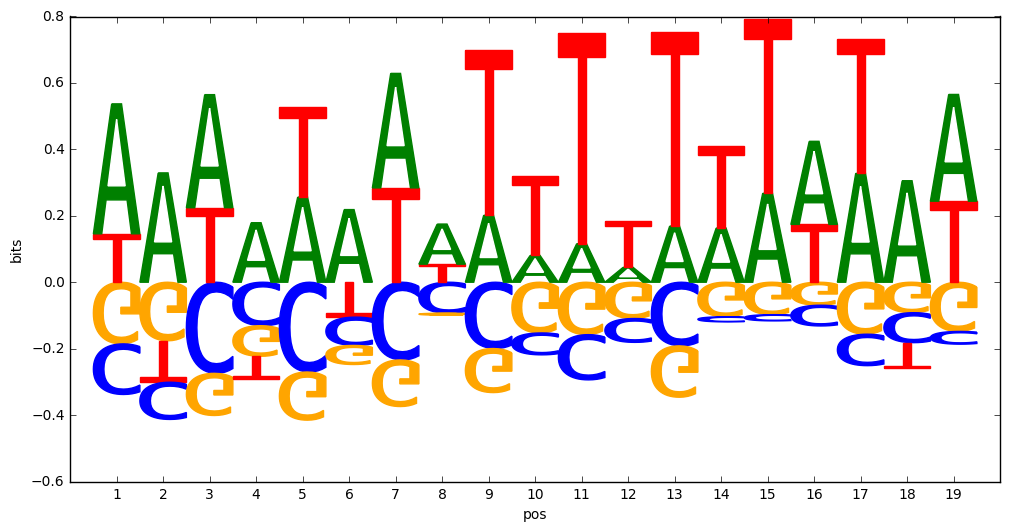

In [26]:
# import matplotlib
# matplotlib.use('Agg')

import matplotlib.pyplot as plt
from dragonn import plot
fig = plot.plot_bases(conv1_weights[:, :, 12])
plt.show()
# fig.savefig('../model_files/regressionJun24Positives/plots/conv1_filter0.png')

In [ ]:
def softmax(matrix):
    probs = np.exp(10*matrix[:, :]) / np.repeat(np.reshape(np.sum(np.exp(10*matrix[:, :]), axis = 1), (19, 1, 300)), 4, axis=1)
    return probs

conv_filters_pwms = softmax(conv1_weights)
print conv_filters_pwms.shape
print conv_filters_pwms[:, :, 0]
print np.argmax(conv_filters_pwms[:, :, 0], axis=1)

In [ ]:
import matplotlib.pyplot as plt
from dragonn import plot
fig = plot.plot_pwm(conv_filters_pwms[:, :, 0])
plt.show()

# Write filters to MEME format for TOMTOM analysis

In [ ]:
np.savetxt("../model_files/regressionJun24Positives/interpretation/motifMatrices_conv1.txt",
           conv_filters_pwms[:, :, 0],
           delimiter = '\t',
           fmt = '%s')

In [ ]:
def filter_to_sequence(matrix):
    maxedMatrix = np.argmax(conv_filters_pwms, axis = 1)
    bases = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    motifMatrix = np.vectorize(bases.get)(maxedMatrix)
    motifMatrix = np.swapaxes(motifMatrix, 0, 1)
    print motifMatrix.shape
    motifs = []
    for arr in motifMatrix:
        arr = list(arr)
        motifs.append(''.join(arr))
    return motifs
    
motifs = filter_to_sequence(conv_filters_pwms)
motifsFile = open('../model_files/regressionJun24Positives/interpretation/conv_filters_transformed_motifs.txt', 'w')
for i in range(len(motifs)):
    motifsFile.write('>conv1_filter' + str(i) + '\n')
    motifsFile.write(motifs[i] + '\n')
motifsFile.close()

In [ ]:
meme = open('../model_files/regressionJun24Positives/interpretation/conv_filters_meme_format.txt', 'w')
meme.write("MEME version 4\n\nALPHABET = ACGT\n\nStrands: + -\n\n" +
           "Background letter frequencies\nA 0.25 C 0.25 G 0.25 T 0.25\n\n")
conv_filter_pwms_reaxis = np.swapaxes(conv_filters_pwms, 0, 2)
conv_filter_pwms_reaxis = np.swapaxes(conv_filter_pwms_reaxis, 1, 2)
for i in range(len(conv_filter_pwms_reaxis)):
# for i in range(2):
    meme.write('MOTIF conv1_filter' + str(i) + '\n')
    meme.write('letter-probability matrix: alength= 4 w= 19\n')
    for j in range(len(conv_filter_pwms_reaxis[i])):
        meme.write(' '.join(conv_filter_pwms_reaxis[i, j].astype(np.str)) + '\n')
    meme.write('\n')

# Compare filters to known motifs using PWM cross-correlation method

In [27]:
import glob
import os, sys
import h5py

import numpy as np
from scipy.signal import correlate2d
import pandas as pd

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

In [28]:
### Define classes and functions
##################################################################
class PWM(object):
    def __init__(self, weights, name=None, threshold=None):
        self.weights = weights
        self.name = name
        self.threshold = threshold

    @staticmethod
    def from_homer_motif(motif_file):
        with open(motif_file) as fp:
            header = fp.readline().strip().split('\t')
            name = header[1]
            threshold = float(header[2])
            weights = np.loadtxt(fp)

        return PWM(weights, name, threshold)

    @staticmethod
    def get_encode_pwms(motif_file):
        pwms = []
        with open(motif_file) as fp:
            line = fp.readline().strip()
            while True:
                if line == '':
                    break

                header = line
                weights = []
                while True:
                    line = fp.readline()
                    if line == '' or line[0] == '>':
                        break
                    weights.append(map(float, line.split()[1:]))
                pwms.append(PWM(np.array(weights), header))
        return pwms

    @staticmethod
    def from_cisbp_motif(motif_file):
        name = os.path.basename(motif_file)
        with open(motif_file) as fp:
            _ = fp.readline()
            weights = np.loadtxt(fp)[:, 1:]
        return PWM(weights, name)

def load_all_pwms():
    homer_path = '../../data/motifs/homer/*.motif'
    homer_pwms = [PWM.from_homer_motif(motif_file)
            for motif_file in glob.glob(homer_path)]

    encode_motifs = '../../data/motifs/encode/motifs.txt'
    encode_pwms = PWM.get_encode_pwms(encode_motifs)

    cisbp_motifs_path = '../../data/motifs/cisbp/*.txt'
    cisbp_annots = pd.read_table("../../data/motifs/cisbp/annots/cisbp_TF_ids.txt")
    cisbp_pwms = [PWM.from_cisbp_motif(motif_file) 
                  for motif_file in glob.glob(cisbp_motifs_path)]

    id_list = cisbp_annots.ix[:,"Motif_ID"].tolist()
    for pwm in cisbp_pwms:
        if pwm.name.split('.txt')[0] in id_list:
            ind = id_list.index(pwm.name.split('.txt')[0])
            pwm.name = cisbp_annots.ix[ind,"TF_Name"]
    return (homer_pwms, encode_pwms, cisbp_pwms)

# Load weights for layer 
def loadWeightsForLayer(h5file, layerName):
    f = h5file
    print f.keys()
#     g=f['layer_{}'.format(layerIdx)] #gets the first layer
#     weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    weights = f[layerName][str(layerName + '_W')]
    weights = np.array(weights)
    weights = np.reshape(weights, (len(weights), len(weights[0, 0]), len(weights[0, 0, 0])))
    return np.array(weights)

# Get the maximal and minimal cross correlation between PWM and Filter
# Notes: can play with fillvalue of 0 or 0.25
def max_min_cross_corr(pwm, conv_filter):
    if conv_filter.shape[1] != 4:
        conv_filter = conv_filter.T
    assert conv_filter.shape[1] == 4
    assert pwm.shape[1] == 4
    
    corr = correlate2d(pwm, conv_filter, mode='same', fillvalue=0.)
    # we are only interested in the part where the 'letter' axes are aligned,
    # and the correlation is over the position axis only, which is in the 2nd
    # column
    allowed_corr = corr[:, 1]
    max_corr = np.max(allowed_corr)
    min_corr = np.min(allowed_corr)

    # max_pos (and min_pos) relates to the alignment between the pwm and the
    # conv_filter as follows - more generally,
    #
    # Position floor(w / 2) - i maps to position 0 on the (padded) PWM
    #
    # where w = width of conv filter, and i is the position given by best_pos
    # (or more generally, the index into allowed_corr). If a negative position
    # is obtained, that means that position 0 on the conv_filter maps to a
    # later position on the PWM.
    max_pos = np.argmax(allowed_corr)
    min_pos = np.argmin(allowed_corr)

    return ((max_corr, max_pos), (min_corr, min_pos))

# Use to get PWM matches for a given filter 
# Normalize filter by max/min activation
def get_pwm_matches_for_filter(conv_filter, pwms, topk=10, bottomk=None):

    min_activation = conv_filter.min(axis=0).sum()
    max_activation = conv_filter.max(axis=0).sum()
    activation_range = max_activation - min_activation

    def norm_cc(cc):
        return (cc - min_activation) / activation_range

    hits = []

    for idx, pwm in enumerate(pwms):
        (max_cc, max_pos), (min_cc, min_pos) = \
            max_min_cross_corr(pwm.weights, conv_filter)
        (max_cc_rc, max_pos_rc), (min_cc_rc, min_pos_rc) = \
            max_min_cross_corr(pwm.weights, conv_filter[::-1,::-1])

        if max_cc_rc > max_cc:
            hits.append((norm_cc(max_cc_rc), max_pos_rc, idx, pwm.name))
        else:
            hits.append((norm_cc(max_cc), max_pos, idx, pwm.name))
        if bottomk != None:
            hits.append((norm_cc(min_cc), min_pos, idx, pwm.name))

        hits.sort(reverse=True)

    if bottomk == None:
        return hits[:topk]
    else:
        return hits[:topk] + hits[-bottomk:]

In [19]:
homer_pwms, encode_pwms, cisbp_pwms = load_all_pwms()

In [20]:
print ("There are " + str(len(homer_pwms)) + " HOMER motifs, " 
       + str(len(encode_pwms)) + " ENCODE motifs, and "
       + str(len(cisbp_pwms)) + " CISBP motifs.")
all_pwms = homer_pwms + encode_pwms + cisbp_pwms
print "In total, there are " + str(len(all_pwms)) + " motifs."

There are 345 HOMER motifs, 2065 ENCODE motifs, and 5099 CISBP motifs.
In total, there are 7509 motifs.


In [29]:
modelID = "record_1_model_aG0ad_"
model_weights_h5 = h5py.File("../model_files/regressionJun24Positives/" + modelID + "modelWeights.h5")
conv_weights = loadWeightsForLayer(model_weights_h5, layerName = 'convolution1d_1')

[u'activation_1', u'batchnormalization_1', u'convolution1d_1', u'dense_1', u'dense_2', u'dropout_1', u'globalaveragepooling1d_1', u'prelu_1']


In [30]:
print conv_weights.shape

(19, 4, 3)


In [31]:
from scipy.stats import pearsonr

print all_pwms[0].weights.shape
print conv_weights[:, :, 0].shape
print correlate2d(all_pwms[0].weights, conv_weights[:, :, 0], mode='same', fillvalue=0.)[:, 1].shape
print correlate2d(all_pwms[0].weights, conv_weights[:, :, 0], mode='same', fillvalue=0.)[:, 1]

print get_pwm_matches_for_filter(conv_weights[:, :, 0], all_pwms, topk=1, bottomk=1)

(15, 4)
(19, 4)
(15,)
[ 0.36603413  0.30969109  0.43335848  0.35985641  0.46321774  0.57216585
  0.43302655  0.54625847  0.55888107  0.52684519  0.50865147  0.44057923
  0.43641494  0.3439565   0.3438527 ]
[(3.365065680530241, 13, 2421, 'SP4'), (-0.93186299354103519, 4, 4964, 'M0127_1.02.txt')]


In [32]:
conv_filter_pwm_matches = [get_pwm_matches_for_filter(conv_filter = conv_weights[:,:,i], 
                                                      pwms = all_pwms, 
                                                      topk = 3, 
                                                      bottomk = 3)
                          for i in range(conv_weights.shape[2])]
# conv_filter_pwm_matches_test = get_pwm_matches_for_filter(conv_filter = conv_weights[:,:,0], 
#                                                           pwms = all_pwms, 
#                                                           topk = 10, 
#                                                           bottomk = None)

In [33]:
conv_filter_pwm_matches = np.array(conv_filter_pwm_matches)

In [41]:
print conv_filter_pwm_matches[:, :, :]

[[['3.36506568053' '13' '2421' 'SP4']
  ['3.06423033139' '10' '5743' 'ZBTB7B']
  ['2.85431429874' '10' '4465' 'EGR1']
  ['-0.880811818535' '7' '2216' '>PROP1_2\tPROP1_jolma_DBD_M626\n']
  ['-0.880812094719' '7' '3663' 'PROP1']
  ['-0.931862993541' '4' '4964' 'M0127_1.02.txt']]

 [['4.31574044988' '13' '2421' 'SP4']
  ['3.91759150755' '10' '5743' 'ZBTB7B']
  ['3.64897985521' '10' '2931' 'EGR1']
  ['-1.22828504814' '9' '3663' 'PROP1']
  ['-1.22915499612' '7' '4964' 'M0127_1.02.txt']
  ['-1.2978492765' '11' '5510' 'M1954_1.02.txt']]

 [['2.35997180159' '16' '2421' 'SP4']
  ['2.04000708824' '3' '13' 'Sp1(Zf)/Promoter/Homer']
  ['2.02031937701' '10' '5743' 'ZBTB7B']
  ['-0.932986853381' '10' '1100' '>FOXP1_1\tFOXP1_transfac_M00987\n']
  ['-0.942110475101' '8' '2510' 'M4356_1.02.txt']
  ['-0.981283976101' '11' '6559' 'ARID3A']]]


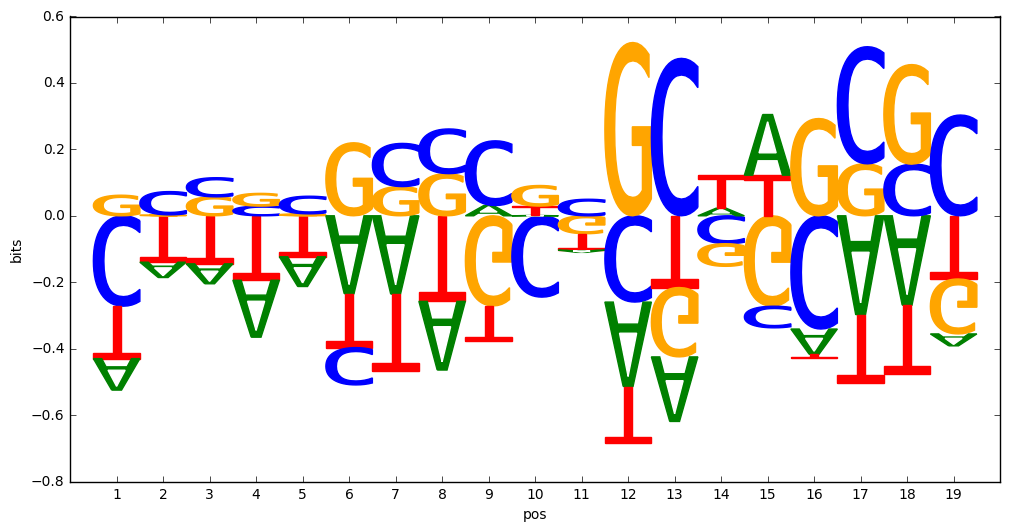

In [45]:
import matplotlib.pyplot as plt
from dragonn import plot
fig = plot.plot_bases(conv1_weights[:, :, 2])
plt.show()

In [34]:
def filter_to_sequence(matrix):
    maxedMatrix = np.argmax(matrix, axis = 1)
    bases = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    motifMatrix = np.vectorize(bases.get)(maxedMatrix)
    motifMatrix = np.swapaxes(motifMatrix, 0, 1)
    print motifMatrix.shape
    motifs = []
    for arr in motifMatrix:
        arr = list(arr)
        motifs.append(''.join(arr))
    return motifs
    
motifs = filter_to_sequence(conv_weights)
motifsFile = open('../model_files/regressionJun24Positives/interpretation/conv_filters_20_transformed_motifs.txt', 'w')
for i in range(len(motifs)):
    motifsFile.write('>conv1_filter' + str(i) + '\n')
    motifsFile.write(motifs[i] + '\n')
motifsFile.close()

(20, 19)


In [ ]:
from dragonn import plot

# Visualize filter and save to plot_name with provided output_prefix and title
def plot_filter_motif(motif_filter, output_prefix, title, plot_name):
    
    # motif_filter = filters[0, ...].squeeze()

    assert len(motif_filter.shape) == 2
    assert 4 in motif_filter.shape

    # May need to transpose as plot_bases takes a N x 4 array
    if motif_filter.shape[0] == 4:
        motif_filter = motif_filter.T

    motif_filter -= motif_filter.mean(axis=1, keepdims=True)
    motif_filter *= 10

    plt.close()
    plot.plot_bases(motif_filter, ylab = 'Weight (x 10)')
    plt.title('{}'.format(title))
    plt.show()
    #     plt.savefig(plot_name)

In [ ]:
plot_filter_motif(conv_weights[:, :, 12],
                output_prefix='',
                title=modelID + ' conv_filter0',
                plot_name='../model_files/regressionJun24Positives/plots/' + modelID + '_conv_filter0')

# DeepLIFT interpretation of top-scoring sequence features

Much of this code is taken from this DeepLIFT Modisco tutorial: https://github.com/kundajelab/deeplift_modisco_tutorial/blob/master/DeepLIFT%20%2B%20MoDISco%20tutorial.ipynb

Also, this is another tutorial that Avanti mentioned that may work better but is harder / requires more dependencies to run: https://github.com/kundajelab/modisco_experiments/blob/master/Nanog/ClusterSeqlets-sequencesGrads.ipynb

In [1]:
%matplotlib inline
# from __future__ import print_function
from simdna import synthetic as sn
import avutils
from avutils import file_processing as fp
import numpy as np
from collections import OrderedDict
# import tutorial_utils
# from tutorial_utils import viz_sequence_highlight_motifs
from deeplift.blobs import NonlinearMxtsMode, DenseMxtsMode
import deeplift
import deeplift.conversion.keras_conversion as kc
from deeplift.visualization import viz_sequence
# import modisco_tutorial

/home/users/rmovva/anaconda2/envs/mommadragonn/lib/python2.7/site-packages/theano/gpuarray/dnn.py:135: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to version 5.1.
  warnings.warn("Your cuDNN version is more recent than "
Using cuDNN version 6020 on context None
Mapped name None to device cuda: Tesla P100-PCIE-16GB (0000:83:00.0)


In [211]:
# Load the keras model, make sure you normalise the weights
# of the first convolutional layer to be mean-centered at each position.
modelName = "record_3_model_AQDDY_"
# modelName = "record_2_model_Yjv2n_"
modelJson = "../model_files/regressionJun24Positives/" + modelName + "modelJson.json"
modelWeights = "../model_files/regressionJun24Positives/" + modelName + "modelWeights.h5"
reload(kc)
keras_model = kc.load_keras_model(modelWeights, json=modelJson)

In [127]:
# normalize weights
W, b = keras_model.layers[0].get_weights()
# print W[:, :, :, 0]
mean_W = np.mean(W, axis = -2)
# print mean_W[:, :, 0]
W = W - mean_W[:, :, None, :]
# print W[:, :, :, 0]
# print b.shape
b = b + np.squeeze(np.sum(mean_W,axis=0))
keras_model.layers[0].set_weights([W, b])

In [16]:
import momma_dragonn
# load the validation set
valid_path = "../hdf5files/regressionJun24Positives_rep2Only/valid_data.hdf5"
data = (momma_dragonn.data_loaders.hdf5_data_loader
              .MultimodalAtOnceDataLoader(path_to_hdf5=valid_path,
                                          strip_enclosing_dictionary=True)
              .get_data())

Input modes [u'sequence']
Output modes [u'output']


In [212]:
data_predictions = keras_model.predict(data.X)
print(data_predictions.shape)

(51838, 1)


In [213]:
from scipy.stats import spearmanr, pearsonr
# prediction performance goes down b/c of the weight normalization. not sure if this is "bad"?
print spearmanr(data_predictions, data.Y)

SpearmanrResult(correlation=0.33382753389063996, pvalue=0.0)


In [214]:
deeplift_model = kc.convert_sequential_model(keras_model,
                                             nonlinear_mxts_mode=deeplift.blobs.NonlinearMxtsMode.DeepLIFT_GenomicsDefault)

# keras_model.layers

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 2 the preceding linear layer is 0 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 6 the preceding linear layer is 4 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 10 the preceding linear layer is 8 of type Conv1D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 14 the preceding linear layer is 13 of type Dense;
In accordance with nonlinea

In [215]:
deeplift_model.get_layers()

In [216]:
# deeplift_prediction_function = deeplift_model.get_prediction_function(
#     inputs=['sequence'],
#     output=['output_act']
# )
deeplift_prediction_function = deeplift_model.get_prediction_function(
    input_layer_idx = 0,
    output_layer_idx = -1
)

In [217]:
print deeplift_prediction_function

<function prediction_function at 0x7f57093bc9b0>


In [218]:
deeplift_model_predictions = deeplift_prediction_function([data.X], batch_size=500)

In [222]:
print spearmanr(deeplift_model_predictions, data.Y)

SpearmanrResult(correlation=0.3338275164345243, pvalue=0.0)


In [219]:
keras_model_predictions = keras_model.predict([data.X], batch_size=500)

In [221]:
print(np.mean(np.abs(deeplift_model_predictions - keras_model_predictions)))
print(np.max(np.abs(deeplift_model_predictions - keras_model_predictions)))
print spearmanr(deeplift_model_predictions, keras_model_predictions)

3.04047e-06
0.000457764
SpearmanrResult(correlation=0.99999999996485234, pvalue=0.0)


In [223]:
deeplift_scoring_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_idx = 0,
                            target_layer_idx = -1)

In [224]:
import sys
import h5py
import numpy as np

def get_background_frequencies(filepath):
    try:
        f = h5py.File(filepath)
    except:
        sys.exit("Either there is no file called " + filepath + ", or it's not an HDF5 file.")
    
    sample = 3000
    indices = np.random.choice(np.arange(len(f['X']['sequence'])), sample, replace = False)
    print len(indices)
    print indices[:10]
    
    sequences = np.take(np.array(f['X']['sequence']), indices, axis=0)
    print sequences[0]
    
    i=0
    baseCounts = [0, 0, 0, 0]
    for seq in sequences:
        if i % 1e2 == 0:
            print i
        for base in seq:
            if float(np.sum(base)) > 0.0:
#                 if i == 0:
#                     print np.sum(base)
                baseCounts[np.argmax(base)] += 1
        i += 1
    
    return np.array(baseCounts) / float(np.sum(baseCounts))

# this could take a while - up to ~15 minutes (approx. numSamples/500 minutes)
valPath = "../hdf5files/regressionJun24Positives/valid_data.hdf5"
backgroundFrequencies = get_background_frequencies(valPath)

3000
[24752 32037  3816 24204 33051 21841 44868  7753 48724 24262]
[[ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 ..., 
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900


In [225]:
# with sample 1000: [ 0.28861706  0.20773624  0.20896315  0.29468356]
print backgroundFrequencies

[ 0.2901785   0.20715891  0.20895831  0.29370428]


In [226]:
# [None,None,:,None] refers to the broadcast pattern; one_hot_data
# has dimensions: sample x channel x rows x columns
# the rows are acgt, the columns refer to the position
# along the sequence, and the channel is a dummy axis for the first input layer.
# Thus, we will broadcast over sample, channel and columns.
print data.X.shape
one_hot_data = np.expand_dims(data.X, axis=1)
print one_hot_data.shape
one_hot_data = np.swapaxes(one_hot_data, 2, 3)
print one_hot_data.shape
# referenceBackground = np.ones_like(one_hot_data)*backgroundFrequencies[None,None,:,None]
referenceBackground = np.ones_like(data.X)*backgroundFrequencies[None,None,:]

(51838, 2000, 4)
(51838, 1, 2000, 4)
(51838, 1, 4, 2000)


In [227]:
print data.X.shape
print one_hot_data.shape
print referenceBackground.shape
# print data.X[0:2, 995:1005, :]
# print(one_hot_data[0:2, :, :, 995:1005])
# print(referenceBackground[0:2, :, :, 995:1005])

(51838, 2000, 4)
(51838, 1, 4, 2000)
(51838, 2000, 4)


In [228]:
task_to_deeplift_scores_unsummed = OrderedDict()
for task_idx in [0]:
    task_to_deeplift_scores_unsummed[task_idx] = np.array(deeplift_scoring_func(
                                                task_idx=task_idx,
                                                input_data_list=[data.X],
                                                input_references_list=[referenceBackground],
                                                batch_size=500,
                                                # if you pass an integer for progress_update, you will get
                                                # a message printed every time that number of items is processed
                                                progress_update=10000))

Done 0
Done 10000
Done 20000
Done 30000
Done 40000
Done 50000


In [229]:
print("Shape: ",str(task_to_deeplift_scores_unsummed[0].shape))
# Notice that the scores of the first few bases are much smaller than the scores of the middle base pairs,
# since the scores of the first and last "base pairs" are actually just the zero pads
print(task_to_deeplift_scores_unsummed[0][0][0:3][:])
print(task_to_deeplift_scores_unsummed[0][0][1000:1003][:])

('Shape: ', '(51838, 2000, 4)')
[[ 0.00281334  0.00034045  0.00228252  0.00525553]
 [-0.00503833  0.00887392 -0.00177699  0.00118046]
 [-0.00033092  0.00239374  0.00716209  0.00022132]]
[[-0.16045864 -0.15955292 -0.06674057 -0.0570619 ]
 [-0.09907652 -0.07776801 -0.20520827 -0.05537084]
 [-0.01101719 -0.01995235 -0.03153621 -0.04855591]]


In [230]:
task_to_deeplift_scores = OrderedDict()
for task in task_to_deeplift_scores_unsummed:
    task_to_deeplift_scores[task] = np.sum(task_to_deeplift_scores_unsummed[task],axis=2)

In [231]:
print task_to_deeplift_scores[0].shape

(51838, 2000)


In [232]:
print data.Y.shape

(51838, 1)


In [233]:
import gzip
fragments = []
valSplitPath = "../splits/regressionJun24Positives/valJun24RegressionPositives.txt.gz"
with gzip.open(valSplitPath) as valNames:
    for line in valNames:
        fragments.append(line.strip())

15
0
Validation datapoint index 34009
Assay fragment score: 1516.18
Predicted fragment score: 452.719
Sequence length: 1425
Genomic region: chr18:39445507-39446932(+)
Top DeepLIFT scored base: chr18:39446823


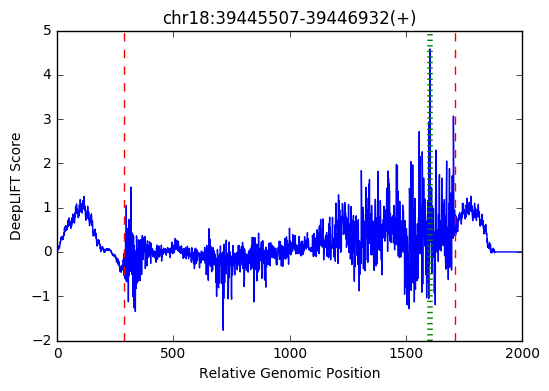

Validation datapoint index 39014
Assay fragment score: 1170.61
Predicted fragment score: 400.573
Sequence length: 1691
Genomic region: chr18:49892612-49894303(-)
Top DeepLIFT scored base: chr18:49894288


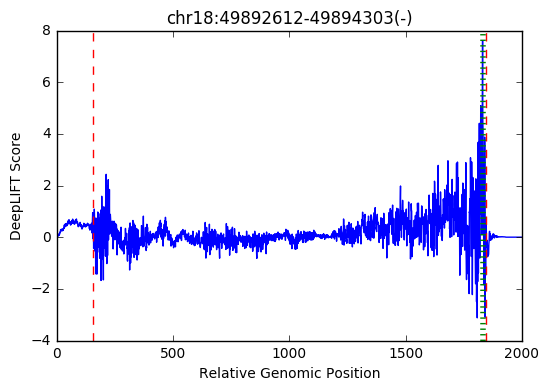

Validation datapoint index 35179
Assay fragment score: 1082.06
Predicted fragment score: 313.814
Sequence length: 1076
Genomic region: chr18:42160952-42162028(+)
Top DeepLIFT scored base: chr18:42161996


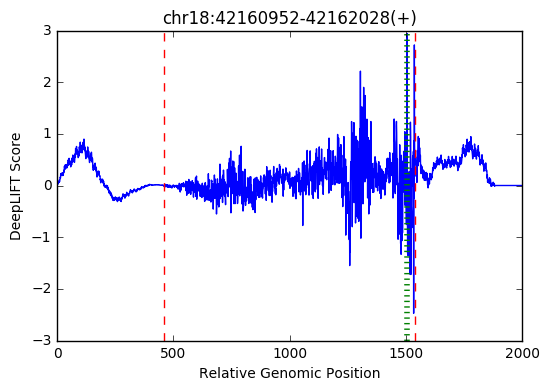

Validation datapoint index 33515
Assay fragment score: 1032.92
Predicted fragment score: 3.18939
Sequence length: 1746
Genomic region: chr18:38733811-38735557(+)
Top DeepLIFT scored base: chr18:38734847


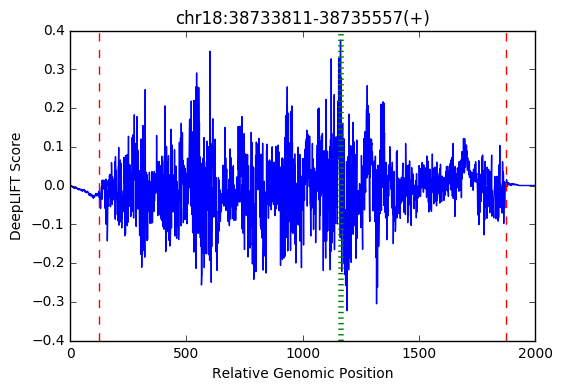

Validation datapoint index 34006
Assay fragment score: 981.088
Predicted fragment score: 426.309
Sequence length: 1448
Genomic region: chr18:39445500-39446948(+)
Top DeepLIFT scored base: chr18:39446824


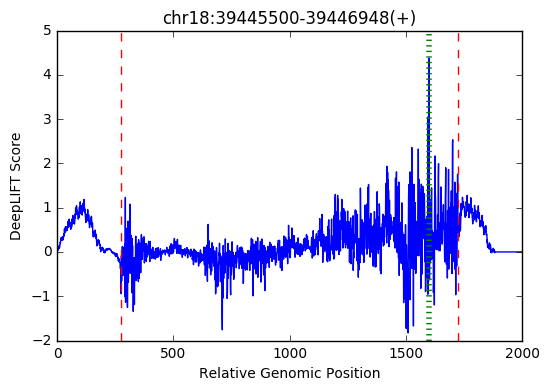

Validation datapoint index 33998
Assay fragment score: 938.432
Predicted fragment score: 431.487
Sequence length: 1714
Genomic region: chr18:39445133-39446847(+)
Top DeepLIFT scored base: chr18:39446824


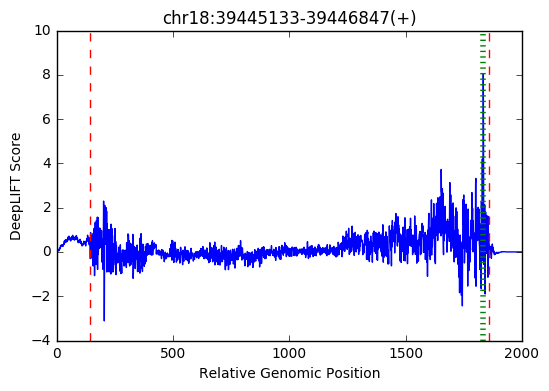

Validation datapoint index 24008
Assay fragment score: 910.354
Predicted fragment score: 336.957
Sequence length: 914
Genomic region: chr18:27303579-27304493(+)
Top DeepLIFT scored base: chr18:27304340


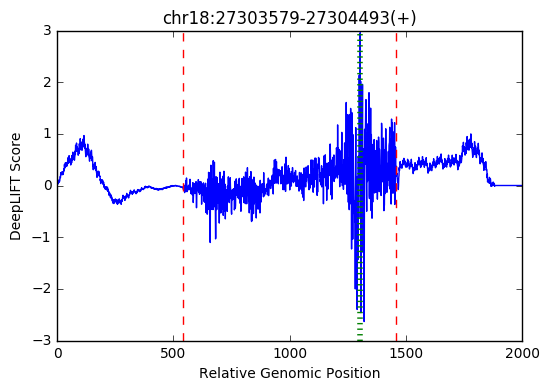

Validation datapoint index 34013
Assay fragment score: 850.96
Predicted fragment score: 426.136
Sequence length: 1303
Genomic region: chr18:39445575-39446878(+)
Top DeepLIFT scored base: chr18:39446823


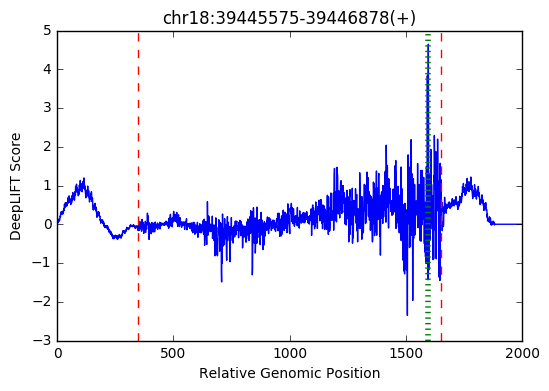

Validation datapoint index 24916
Assay fragment score: 708.413
Predicted fragment score: 479.201
Sequence length: 1595
Genomic region: chr18:28418490-28420085(-)
Top DeepLIFT scored base: chr18:28420080


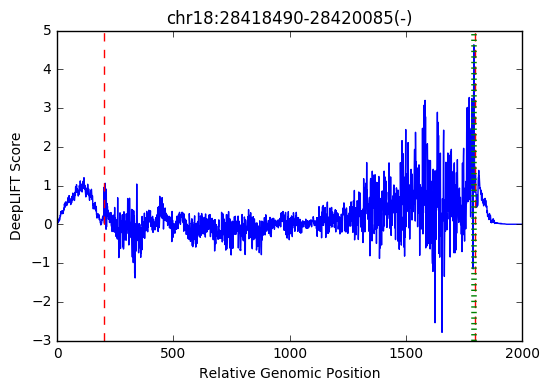

Validation datapoint index 24863
Assay fragment score: 671.697
Predicted fragment score: 459.368
Sequence length: 1584
Genomic region: chr18:28368081-28369665(+)
Top DeepLIFT scored base: chr18:28369664


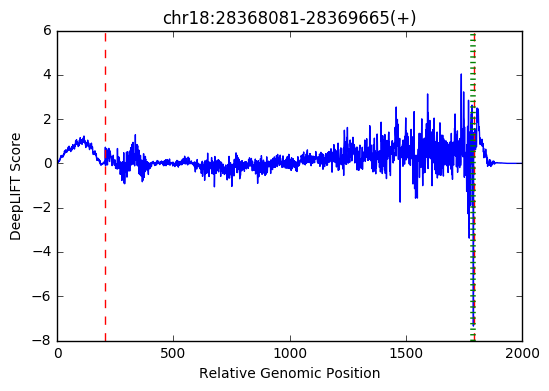

Validation datapoint index 13208
Assay fragment score: 639.3
Predicted fragment score: 67.2092
Sequence length: 238
Genomic region: chr18:12991125-12991363(-)
Top DeepLIFT scored base: chr18:12991202


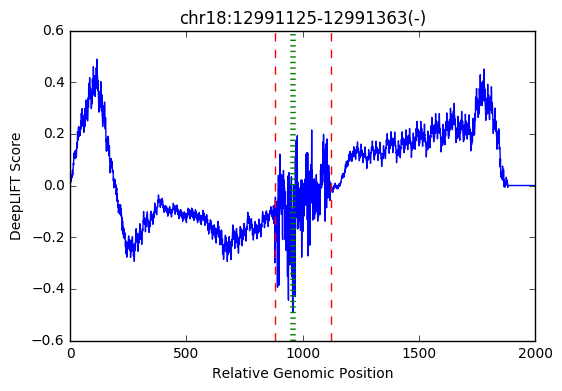

Validation datapoint index 50163
Assay fragment score: 633.9
Predicted fragment score: 440.91
Sequence length: 1126
Genomic region: chr18:74489324-74490450(+)
Top DeepLIFT scored base: chr18:74490419


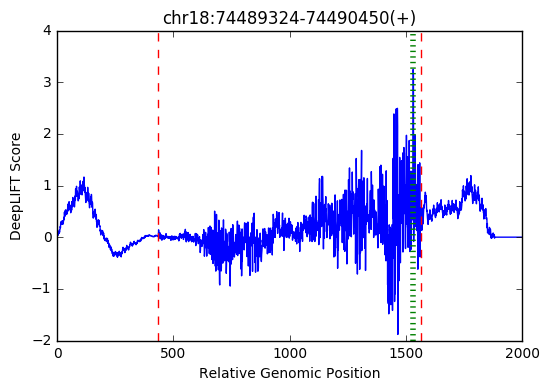

Validation datapoint index 35175
Assay fragment score: 610.143
Predicted fragment score: 315.911
Sequence length: 1368
Genomic region: chr18:42160404-42161772(+)
Top DeepLIFT scored base: chr18:42161757


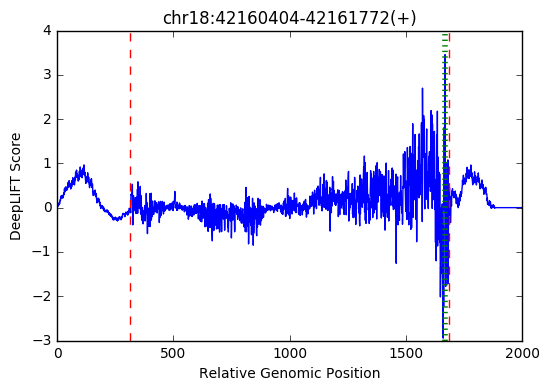

Validation datapoint index 34019
Assay fragment score: 599.344
Predicted fragment score: 239.763
Sequence length: 1459
Genomic region: chr18:39445634-39447093(+)
Top DeepLIFT scored base: chr18:39447079


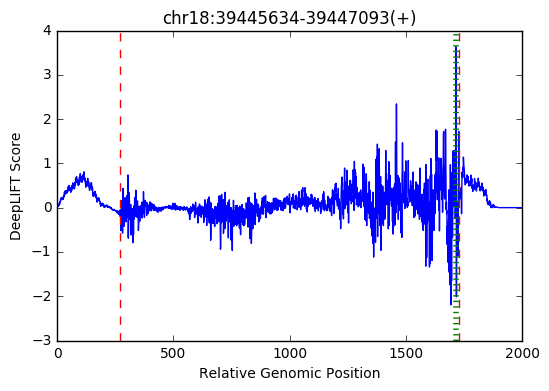

Validation datapoint index 10148
Assay fragment score: 591.784
Predicted fragment score: 5.10685
Sequence length: 1107
Genomic region: chr18:9492660-9493767(+)
Top DeepLIFT scored base: chr18:9493303


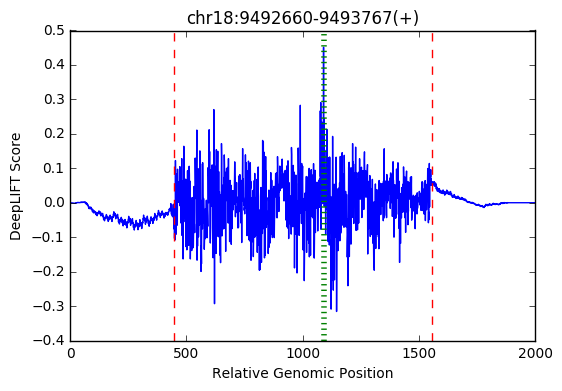

In [239]:
import matplotlib.pyplot as plt
# print np.argmax(data.Y)
top_idxs = np.argsort(np.squeeze(data.Y, axis=1), axis = 0)[::-1][:15]

# curating the ones that were predicted accurately -- i.e., prediction within some percentage of true value
top_idxs_curated = []
for idx in top_idxs:
    percentThreshold = 30.0
    true_score = data.Y[idx]
    pred_score = deeplift_model_predictions[idx]
    if (pred_score > (1 - percentThreshold / 100) * true_score and 
        pred_score < (1 + percentThreshold / 100) * true_score):
        top_idxs_curated.append(idx)
    
print len(top_idxs)
print len(top_idxs_curated)

for idx in top_idxs:
# for idx in top_idxs_curated:
    print "Validation datapoint index " + str(idx)
    print "Assay fragment score: " + str(data.Y[idx][0])
    print "Predicted fragment score: " + str(deeplift_model_predictions[idx][0])
    plt.plot(task_to_deeplift_scores[0][idx])
    seqLen = np.sum(data.X[idx])
    print "Sequence length: " + str(int(seqLen))
    plt.axvline(x = 1000 - seqLen/2 - 1, color = 'r', linestyle = '--')
    plt.axvline(x = 1000 + seqLen/2 + 1, color = 'r', linestyle = '--')
    topBase = np.argmax(np.abs(task_to_deeplift_scores[0][idx]))
    plt.axvline(x = topBase, color = 'g', linewidth = 4, linestyle = ':')
    
    fragment = fragments[idx]
    print "Genomic region: " + fragment
    centerPos = int(fragment[fragment.find(":") + 1 : fragment.find("-")]) + seqLen / 2
    topBasePos = int(centerPos + topBase - 1000)
    chrom = fragment[:fragment.find(":")]
    print "Top DeepLIFT scored base: " + chrom + ":" + str(topBasePos)
    plt.title(fragment)
    plt.xlabel("Relative Genomic Position")
    plt.ylabel("DeepLIFT Score")
    plt.show()
    plt.clf()